# Deep Learning Project: Image Classification

### Project Overview  
This project focuses on solving computer vision problems using deep learning techniques:  

**Image Classification with Deep Neural Networks (DNN) and Convolutional Neural Networks (CNN).**  
   The goal is to build and fine-tune models that can accurately classify images into predefined categories.  

# Motivation  
Image understanding is one of the most impactful applications of artificial intelligence today, powering areas such as medical imaging, autonomous vehicles, e-commerce, and assistive technology.  

This project was designed to:  
- Explore the implementation of deep learning models for **image recognition**.  
- Train, evaluate, and fine-tune CNNs for improved classification performance.  
- Experiment with **regularization techniques** such as data augmentation and dropout to address overfitting.  
- Benchmark model performance and track improvements across different approaches.  
- Extend the problem to **image captioning** using RNNs, bridging the gap between computer vision and natural language processing.  
- Visualize predictions to evaluate how well the models capture semantic information from images.

### Tools and Technologies  
The project is implemented in **Python** using **PyTorch** as the deep learning framework. Key libraries used include:  
- **Torchvision** for image preprocessing and dataset handling.  
- **Matplotlib / Seaborn** for data visualization.  
- **NumPy / Pandas** for data manipulation and analysis.  
- **GPU acceleration** (CUDA) to speed up training on large datasets. 

### Approach  

#### Part 1: Image Classification  
- Built a baseline Deep Neural Network (DNN).  
- Developed and trained Convolutional Neural Networks (CNNs) to capture spatial hierarchies in image data.  
- Applied techniques such as data augmentation, dropout, and batch normalization to improve generalization.  
- Evaluated models using accuracy, loss curves, and confusion matrices.

In [ ]:
import cv2
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import time

In [ ]:
# always check your version
print(torch.__version__)

2.1.0+cu121


Using CUDA for GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Creating csv file for all the 30 labels in the TinyImageNet30 dataset

In [ ]:
def create_csv(dataset_path, output_csv):
    if not os.path.exists(dataset_path):
        print("Dataset path does not exist.")
        return

    label_map = {}
    label_count = 0

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)

        if os.path.isdir(class_path):
            label_map[class_folder] = label_count
            label_count += 1

    with open(output_csv, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        csv_writer.writerow(['Image', 'Label'])

        for class_folder in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_folder)

            if os.path.isdir(class_path):
                label = label_map[class_folder]

                for image_file in os.listdir(class_path):
                    csv_writer.writerow([image_file, label])

dataset_path = '/content/dataset/train_set/train_set/train_set'

output_csv = 'image_labels.csv'

create_csv(dataset_path, output_csv)

In [ ]:
train_dir='/content/dataset/train_set/train_set/train_set'
test_dir='/content/dataset/test_set/test_set/test_set'
test_dataframe = '/content/dataset/asachandasach/test_set/test_set/test_set'

train_data_path = 'image_labels.csv'
train_data = pd.read_csv(train_data_path)

In [ ]:
labelArr = train_data['Label'].unique()

label2id = {}
id2label = {}
index = 0
for  class_name in labelArr:
    label2id[class_name] = str(index)
    id2label[str(index)] = class_name
    index=index +1
print(label2id)

{'baboon': '0', 'banana': '1', 'bee': '2', 'bison': '3', 'butterfly': '4', 'candle': '5', 'cardigan': '6', 'chihuahua': '7', 'elephant': '8', 'espresso': '9', 'fly': '10', 'goldfish': '11', 'goose': '12', 'grasshopper': '13', 'hourglass': '14', 'icecream': '15', 'ipod': '16', 'jellyfish': '17', 'koala': '18', 'ladybug': '19', 'lion': '20', 'mushroom': '21', 'penguin': '22', 'pig': '23', 'pizza': '24', 'pretzel': '25', 'redpanda': '26', 'refrigerator': '27', 'sombrero': '28', 'umbrella': '29'}


## Function implementations


In [ ]:
class ImgDataset(Dataset):

    def __init__(self, dataframe, root_dir,is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx, 1],
                                self.dataframe.iloc[idx, 0])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(label2id[labelKey]))

        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,label

In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_data, test_size=0.2, stratify=train_data['Label'], random_state=0)

In [ ]:
torch.manual_seed(0)
train_dataset = ImgDataset (train,root_dir='/content/dataset/train_set/train_set/train_set', is_train=True, transform=transforms.ToTensor())
valid_dataset = ImgDataset (valid,root_dir='/content/dataset/train_set/train_set/train_set', is_train=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle = False)

### Defining a MLP model class

<u>Creating a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 3 * 64 * 64
hidden_size = 64
output_size = 30
batch_size = 64
num_epochs = 100

model_mlp = MLP(input_size, hidden_size, output_size)
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(model_mlp.parameters())

### Defining a CNN model class

<u>Creating a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers
- Loss function
- Optimiser


In [ ]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        return x

cnn_model = CNN()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)


## Model training


### Training both MLP and CNN model - showing loss and accuracy graphs

In [ ]:
cnn_model = cnn_model.to(device)

In [ ]:
model_mlp = model_mlp.to(device)

In [ ]:
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, topk=(1,)):
    best_loss = float('inf')
    current_patience = 0
    best_model_state = None
    loss_list = []
    accuracy_list = []
    val_accuracy_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        topk_correct = [0] * len(topk)

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            batch_topk_correct = topk_accuracy(outputs, labels, topk)
            for i, k in enumerate(topk):
                topk_correct[i] += batch_topk_correct[i]

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / total
        loss_list.append(epoch_loss)
        accuracy_list.append(accuracy)

        epoch_topk_accuracy = [c / total for c in topk_correct]

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, ', end='')
        for i, k in enumerate(topk):
            print(f'Top-{k} Accuracy: {epoch_topk_accuracy[i]:.2f}%', end='')
            if i < len(topk) - 1:
                print(', ', end='')
        print()

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_topk_correct = [0] * len(topk)

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)

                batch_val_topk_correct = topk_accuracy(val_outputs, val_labels, topk)
                for i, k in enumerate(topk):
                    val_topk_correct[i] += batch_val_topk_correct[i]

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * val_correct / val_total
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_epoch_loss)

        val_epoch_topk_accuracy = [c / val_total for c in val_topk_correct]

        print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.2f}%, ', end='')
        for i, k in enumerate(topk):
            print(f'Top-{k} Accuracy: {val_epoch_topk_accuracy[i]:.2f}%', end='')
            if i < len(topk) - 1:
                print(', ', end='')
        print()

        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            current_patience = 0
            best_model_state = model.state_dict()
        else:
            current_patience += 1
            if current_patience >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    model.load_state_dict(best_model_state)

    return model, loss_list, accuracy_list, val_loss_list, val_accuracy_list, val_epoch_topk_accuracy

In [ ]:
%%time
patience = 20
topk=(1, 3, 5)

mlp_model, mlp_loss_list, mlp_accuracy_list, mlp_val_loss_list, mlp_val_accuracy_list, mlp_topk = train_with_early_stopping(model_mlp, train_loader, val_loader, criterion_mlp, optimizer_mlp, num_epochs, patience, topk)

Training - Epoch [1/100], Loss: 3.3518, Accuracy: 6.23%, Top-1 Accuracy: 0.39%, Top-3 Accuracy: 0.91%, Top-5 Accuracy: 1.36%

Validation - Epoch [1/100], Loss: 3.2573, Accuracy: 8.22%, Top-1 Accuracy: 0.26%, Top-3 Accuracy: 0.60%, Top-5 Accuracy: 0.91%

Training - Epoch [2/100], Loss: 3.2092, Accuracy: 8.13%, Top-1 Accuracy: 0.51%, Top-3 Accuracy: 1.29%, Top-5 Accuracy: 1.92%

Validation - Epoch [2/100], Loss: 3.1758, Accuracy: 9.26%, Top-1 Accuracy: 0.29%, Top-3 Accuracy: 0.71%, Top-5 Accuracy: 1.01%

Training - Epoch [3/100], Loss: 3.1582, Accuracy: 9.20%, Top-1 Accuracy: 0.58%, Top-3 Accuracy: 1.42%, Top-5 Accuracy: 2.18%

Validation - Epoch [3/100], Loss: 3.1309, Accuracy: 9.74%, Top-1 Accuracy: 0.31%, Top-3 Accuracy: 0.73%, Top-5 Accuracy: 1.14%

Training - Epoch [4/100], Loss: 3.1385, Accuracy: 9.74%, Top-1 Accuracy: 0.61%, Top-3 Accuracy: 1.51%, Top-5 Accuracy: 2.24%

Validation - Epoch [4/100], Loss: 3.1084, Accuracy: 10.37%, Top-1 Accuracy: 0.33%, Top-3 Accuracy: 0.79%, Top-5 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_graphs(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, model_name):
    max_length = len(train_loss_list)

    epochs = range(1, max_length + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss_list[:max_length], label='Training Loss', color='red')
    plt.plot(epochs, val_loss_list[:max_length], label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Losses vs Epochs')
    plt.legend()

    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracy_list[:max_length], label='Training Accuracy', color='red')
    plt.plot(epochs, val_accuracy_list[:max_length], label='Validation Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Training and Validation Accuracy vs Epochs')
    plt.legend()

    plt.show()


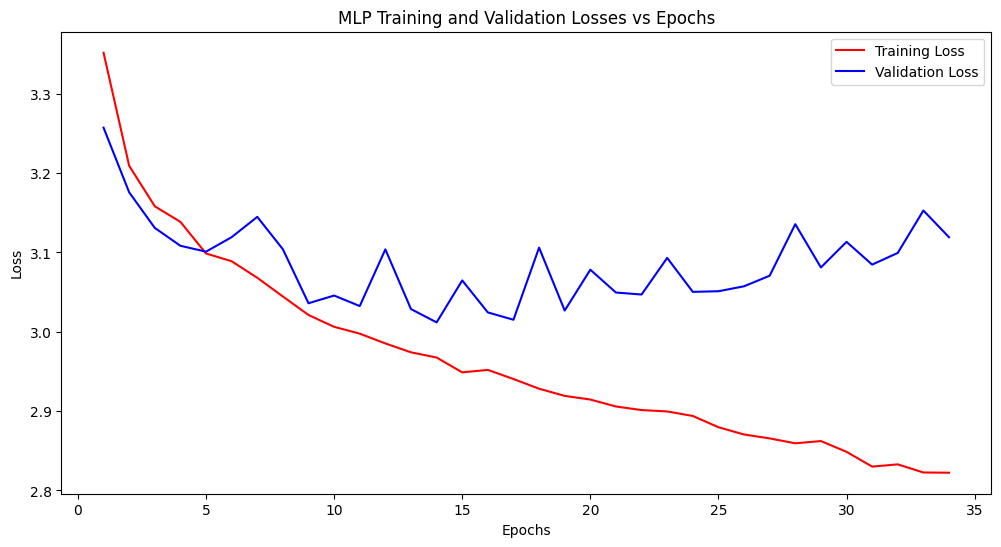

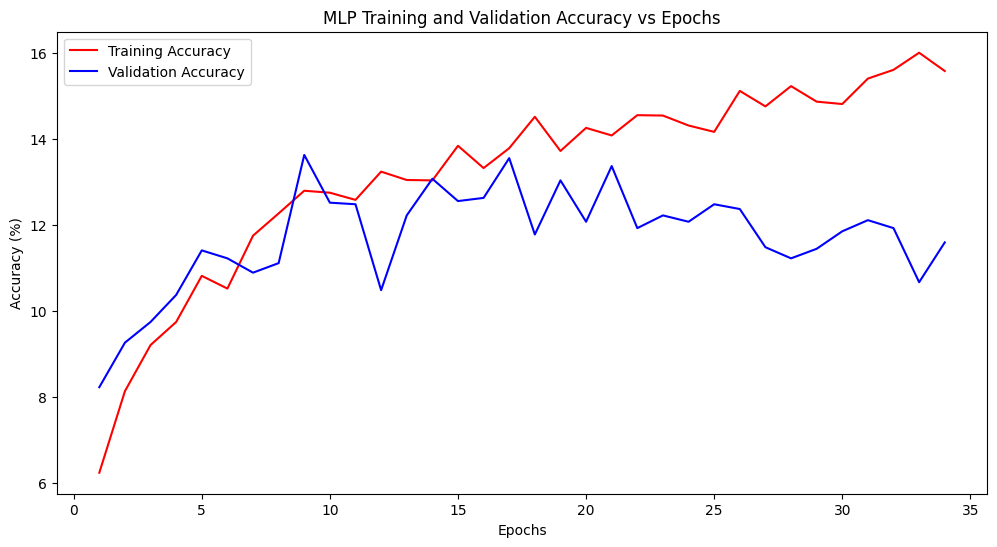

In [ ]:
plot_graphs(mlp_loss_list, mlp_accuracy_list, mlp_val_loss_list, mlp_val_accuracy_list, 'MLP')

In [ ]:
%%time
patience = 15
topk=(1, 3, 5)

model_cnn, cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, cnn_topk = train_with_early_stopping(cnn_model, train_loader, val_loader, criterion_cnn, optimizer_cnn, num_epochs, patience, topk)

torch.save(model_cnn.state_dict(), 'trained_cnn_model_2.1_.pth')

Training - Epoch [1/100], Loss: 2.7223, Accuracy: 21.79%, Top-1 Accuracy: 1.36%, Top-3 Accuracy: 2.64%, Top-5 Accuracy: 3.42%

Validation - Epoch [1/100], Loss: 2.4466, Accuracy: 27.15%, Top-1 Accuracy: 0.85%, Top-3 Accuracy: 1.66%, Top-5 Accuracy: 2.06%

Training - Epoch [2/100], Loss: 2.1999, Accuracy: 35.62%, Top-1 Accuracy: 2.23%, Top-3 Accuracy: 3.74%, Top-5 Accuracy: 4.52%

Validation - Epoch [2/100], Loss: 2.3611, Accuracy: 32.81%, Top-1 Accuracy: 1.03%, Top-3 Accuracy: 1.82%, Top-5 Accuracy: 2.22%

Training - Epoch [3/100], Loss: 1.9188, Accuracy: 43.35%, Top-1 Accuracy: 2.71%, Top-3 Accuracy: 4.25%, Top-5 Accuracy: 4.94%

Validation - Epoch [3/100], Loss: 1.9437, Accuracy: 42.70%, Top-1 Accuracy: 1.34%, Top-3 Accuracy: 2.09%, Top-5 Accuracy: 2.42%

Training - Epoch [4/100], Loss: 1.6880, Accuracy: 50.13%, Top-1 Accuracy: 3.13%, Top-3 Accuracy: 4.59%, Top-5 Accuracy: 5.21%

Validation - Epoch [4/100], Loss: 1.8894, Accuracy: 45.48%, Top-1 Accuracy: 1.43%, Top-3 Accuracy: 2.16%,

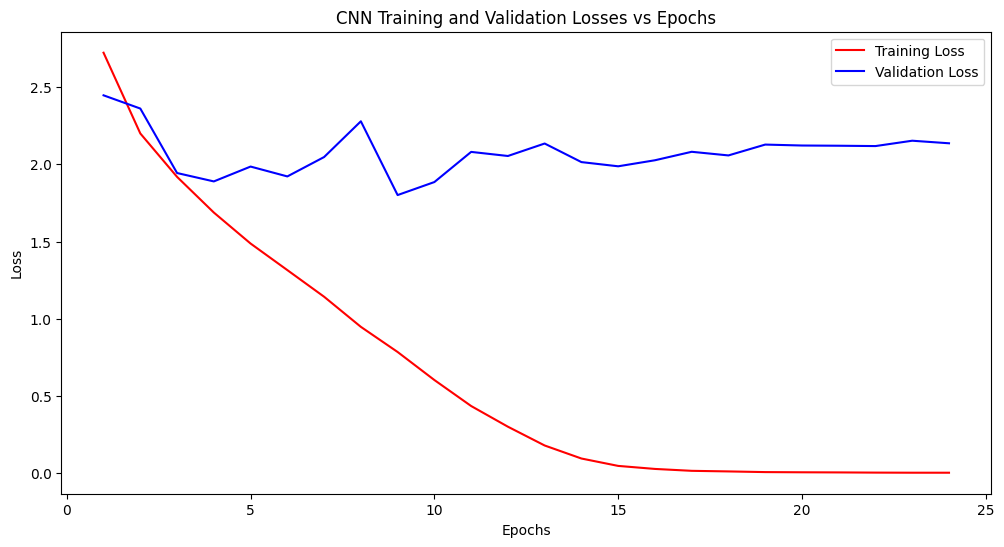

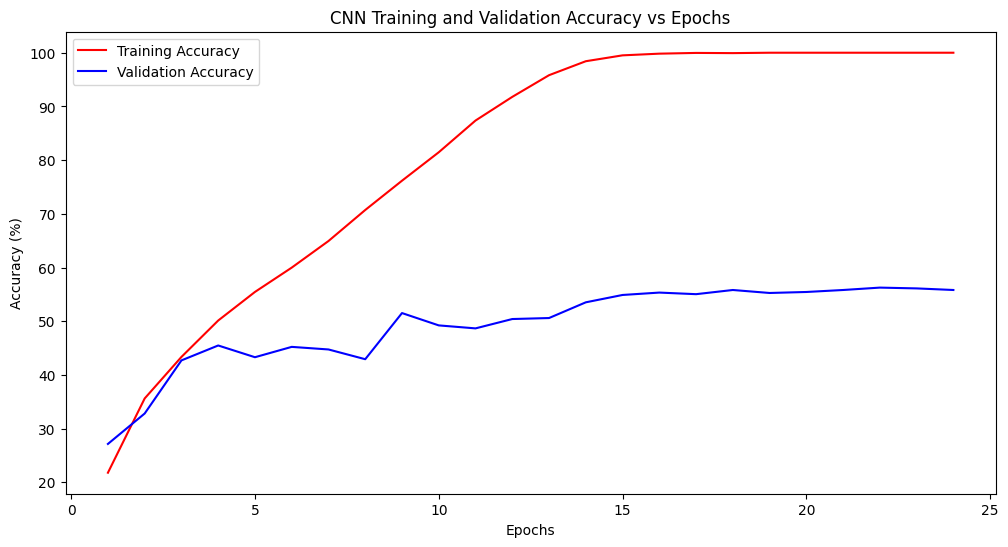

In [ ]:
plot_graphs(cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, 'CNN')

###Comments:
1. Multi-Layer Perceptron(MLP):
  *   The MLP model consists of an input layer, a single hidden layer, and an output layer.
  *   ReLU activation function is applied after the fully connected layers to introduce non-linearity.
  *   After being trained on the TinyImageNet30 dataset for 34 epochs, the model showed an accuracy of 15% and 11% on the training and validation dataset respectively which consists of 10,800 and 2,700 images respectively for 30 classes.
Convolutional Neural Network (CNN):
2. Convolutional Neural Network(CNN):
  * The CNN consists a series of convolutional layers followed by batch normalization, ReLU activation, and max-pooling layers.
  * Four convolutional layers increasing the number of output channels from 32 to 256.
  * Four max-pooling layers are utilized to downsample feature maps.
  * After being trained on the TinyImageNet30 dataset for 24 epochs, the model showed an accuracy of 100% and 55% on the training and validation dataset respectively indicating overfitting of the data.
3. Why one should use CNN over MLP for the image classification problem.
  * CNNs utilize parameter sharing and local receptive fields, which making them more efficient as compared to MLP.
  * CNNs are efficient in learning translated images due to the use of convolutional and pooling layers. MLP lacks this property.
  * CNNs exploit the spatial structure of images by using sparse connectivity.
  * These factors make CNNs the preferred choice for tasks like image classification and recognition.

### Generating confusion matrix and ROC curves

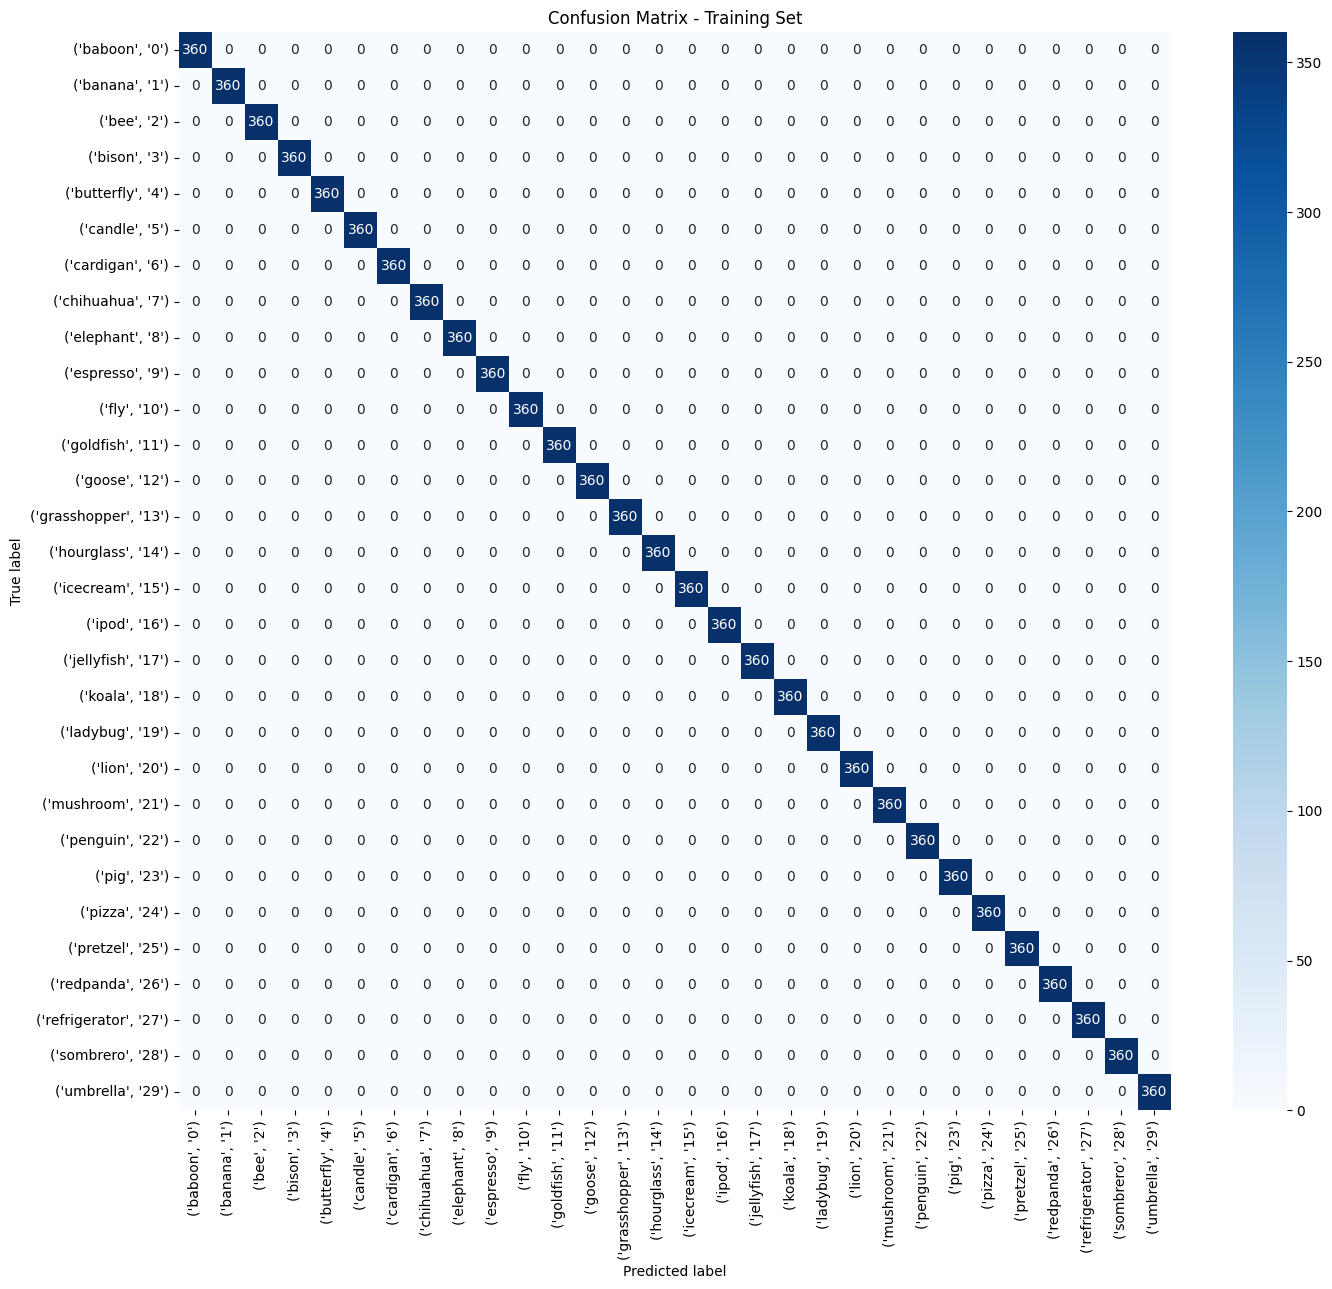

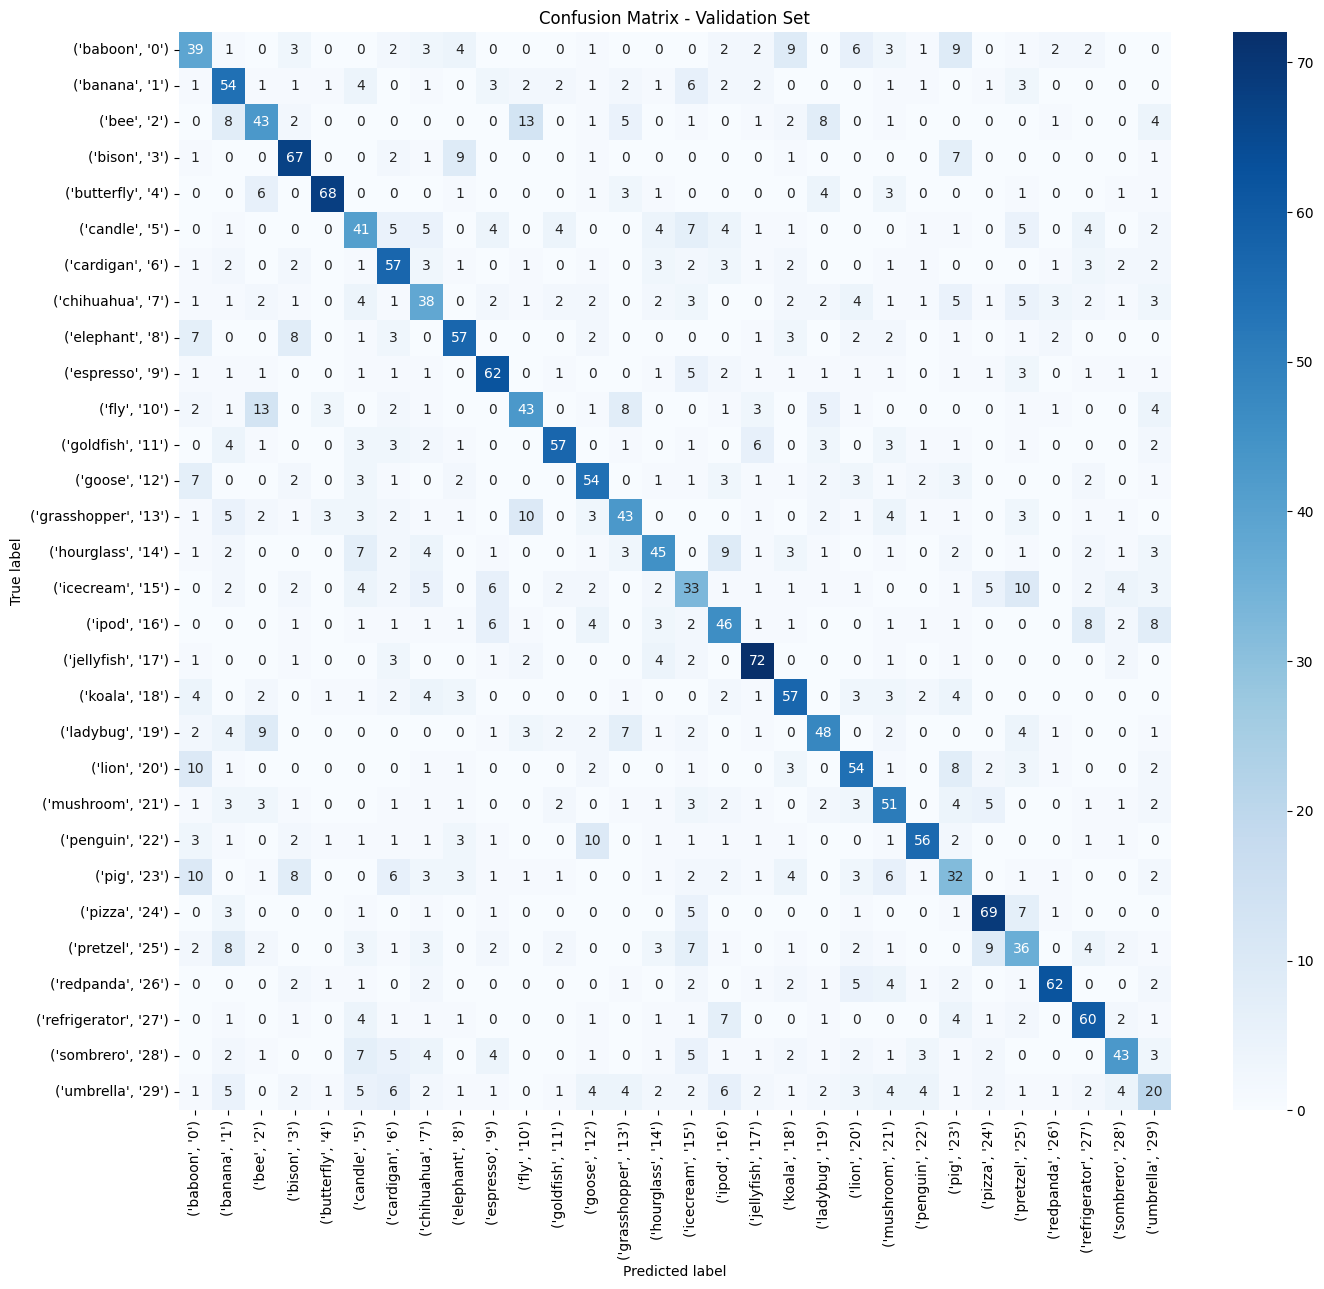

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, data_loader):
    predictions = []
    true_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks()
    plt.yticks()
    plt.show()

train_predictions, train_true_labels = evaluate_model(cnn_model, train_loader)
val_predictions, val_true_labels = evaluate_model(cnn_model, val_loader)

class_names = list(label2id.items())

train_conf_matrix = confusion_matrix(train_true_labels, train_predictions)
val_conf_matrix = confusion_matrix(val_true_labels, val_predictions)

plot_confusion_matrix(train_conf_matrix, classes=class_names, title='Confusion Matrix - Training Set')
plot_confusion_matrix(val_conf_matrix, classes=class_names, title='Confusion Matrix - Validation Set')


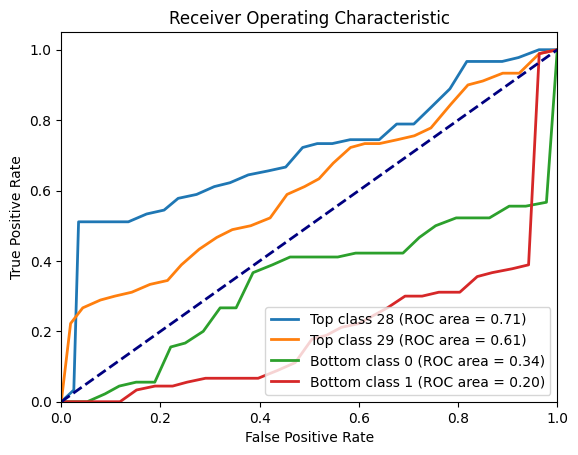

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fpr, tpr, roc_auc, top_classes, bottom_classes):
    plt.figure()
    lw = 2
    for i in range(len(fpr)):
        if i < len(top_classes):
            label = 'Top class %d (ROC area = %0.2f)' % (top_classes[i], roc_auc[i])
        else:
            label = 'Bottom class %d (ROC area = %0.2f)' % (bottom_classes[i-len(top_classes)], roc_auc[i])
        plt.plot(fpr[i], tpr[i], lw=lw, label=label)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

train_predictions, train_true_labels = evaluate_model(cnn_model, train_loader)
val_predictions, val_true_labels = evaluate_model(cnn_model, val_loader)

top_classes = np.argsort(np.sum(train_conf_matrix, axis=0))[-2:]
bottom_classes = np.argsort(np.sum(train_conf_matrix, axis=0))[:2]

fpr = []
tpr = []
roc_auc = []
for cls in top_classes:
    fpr_cls, tpr_cls, _ = roc_curve(val_true_labels, val_predictions, pos_label=cls)
    roc_auc_cls = auc(fpr_cls, tpr_cls)
    fpr.append(fpr_cls)
    tpr.append(tpr_cls)
    roc_auc.append(roc_auc_cls)

for cls in bottom_classes:
    fpr_cls, tpr_cls, _ = roc_curve(val_true_labels, val_predictions, pos_label=cls)
    roc_auc_cls = auc(fpr_cls, tpr_cls)
    fpr.append(fpr_cls)
    tpr.append(tpr_cls)
    roc_auc.append(roc_auc_cls)

plot_roc_curve(fpr, tpr, roc_auc, top_classes, bottom_classes)


### Strategies for tackling overfitting

*   Data augmentation
*   Dropout
*   Hyperparameter tuning (e.g. changing learning rate)

In [ ]:
mean = [0.3386, 0.3875, 0.4180] # Calculated for this specific dataset
std = [0.2329, 0.2463, 0.2537]

transform_train = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])
transform_valid = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

In [ ]:
train_dataset = ImgDataset (train,root_dir='/content/dataset/train_set/train_set/train_set', is_train=True, transform=transform_train)
valid_dataset = ImgDataset (valid,root_dir='/content/dataset/train_set/train_set/train_set', is_train=True, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
cnn_model = CNN()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters())

In [ ]:
cnn_model.load_state_dict(torch.load('trained_cnn_model_2.1_.pth'))

<All keys matched successfully>

In [ ]:
cnn_model = cnn_model.to(device)

In [ ]:
model_cnn, cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, cnn_topk = train_with_early_stopping(cnn_model, train_loader, val_loader, criterion_cnn, optimizer_cnn, num_epochs, patience, topk)
torch.save(model_cnn.state_dict(), 'trained_cnn_model_2.3.1_.pth')

Training - Epoch [1/100], Loss: 3.6802, Accuracy: 11.46%, Top-1 Accuracy: 0.18%, Top-3 Accuracy: 0.41%, Top-5 Accuracy: 0.59%

Validation - Epoch [1/100], Loss: 2.9089, Accuracy: 16.41%, Top-1 Accuracy: 0.26%, Top-3 Accuracy: 0.57%, Top-5 Accuracy: 0.80%

Training - Epoch [2/100], Loss: 2.8656, Accuracy: 18.20%, Top-1 Accuracy: 0.28%, Top-3 Accuracy: 0.58%, Top-5 Accuracy: 0.79%

Validation - Epoch [2/100], Loss: 2.7558, Accuracy: 20.44%, Top-1 Accuracy: 0.32%, Top-3 Accuracy: 0.67%, Top-5 Accuracy: 0.90%

Training - Epoch [3/100], Loss: 2.7539, Accuracy: 20.80%, Top-1 Accuracy: 0.33%, Top-3 Accuracy: 0.64%, Top-5 Accuracy: 0.85%

Validation - Epoch [3/100], Loss: 2.4558, Accuracy: 27.85%, Top-1 Accuracy: 0.44%, Top-3 Accuracy: 0.83%, Top-5 Accuracy: 1.05%

Training - Epoch [4/100], Loss: 2.6536, Accuracy: 23.75%, Top-1 Accuracy: 0.37%, Top-3 Accuracy: 0.71%, Top-5 Accuracy: 0.92%

Validation - Epoch [4/100], Loss: 2.5739, Accuracy: 27.67%, Top-1 Accuracy: 0.44%, Top-3 Accuracy: 0.81%,

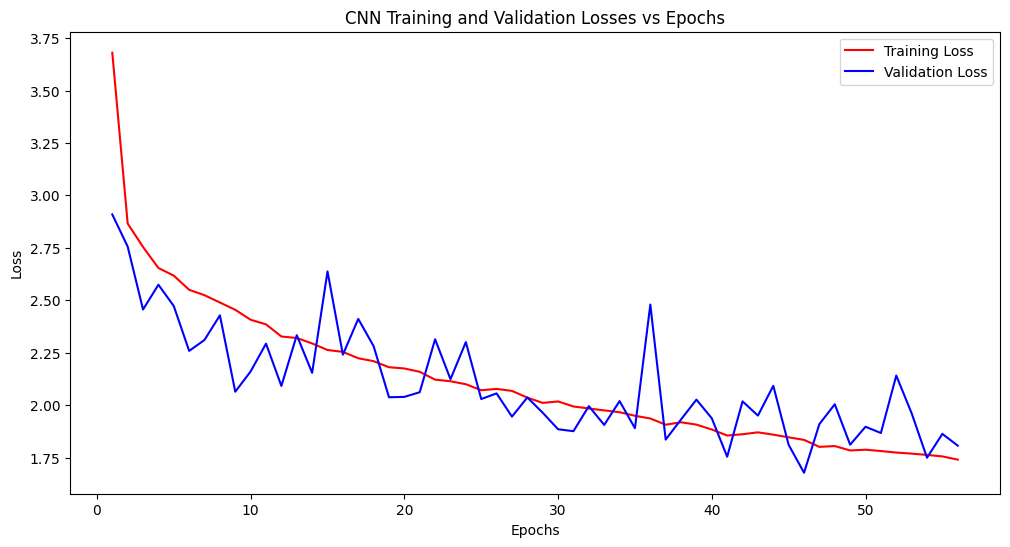

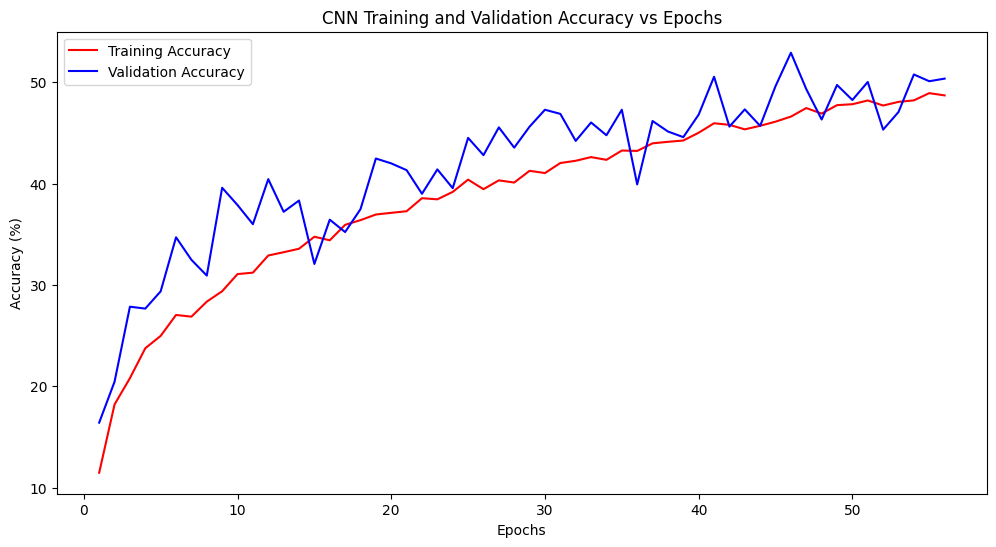

In [ ]:
plot_graphs(cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, 'CNN')

#### Dropout 


In [ ]:
cnn_model.load_state_dict(torch.load('trained_cnn_model_2.3.1_.pth'))

<All keys matched successfully>

In [ ]:
cnn_model = cnn_model.to(device)

In [ ]:
import torch.nn as nn

dropout_prob = 0.5

class ModCNN(nn.Module):
    def __init__(self, pretrained_model):
        super(ModCNN, self).__init__()
        self.pretrained_model = pretrained_model
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.dropout(x)
        return x

modified_cnn_model = ModCNN(cnn_model)


In [ ]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(modified_cnn_model.parameters())

modified_cnn_model = modified_cnn_model.to(device)

patience = 10
topk=(1,3,5)
new_model_cnn, cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, cnn_topk = train_with_early_stopping(modified_cnn_model, train_loader, val_loader, criterion_cnn, optimizer_cnn, num_epochs, patience, topk)
torch.save(model_cnn.state_dict(), 'trained_cnn_model_2.3.2__.pth')

Training - Epoch [1/100], Loss: 3.4845, Accuracy: 15.19%, Top-1 Accuracy: 0.96%, Top-3 Accuracy: 1.88%, Top-5 Accuracy: 2.80%

Validation - Epoch [1/100], Loss: 2.6911, Accuracy: 28.04%, Top-1 Accuracy: 0.88%, Top-3 Accuracy: 1.62%, Top-5 Accuracy: 2.04%

Training - Epoch [2/100], Loss: 2.9229, Accuracy: 20.69%, Top-1 Accuracy: 1.31%, Top-3 Accuracy: 2.40%, Top-5 Accuracy: 3.60%

Validation - Epoch [2/100], Loss: 2.3820, Accuracy: 34.93%, Top-1 Accuracy: 1.10%, Top-3 Accuracy: 1.82%, Top-5 Accuracy: 2.23%

Training - Epoch [3/100], Loss: 2.7790, Accuracy: 24.41%, Top-1 Accuracy: 1.56%, Top-3 Accuracy: 2.75%, Top-5 Accuracy: 4.01%

Validation - Epoch [3/100], Loss: 2.4659, Accuracy: 29.78%, Top-1 Accuracy: 0.93%, Top-3 Accuracy: 1.67%, Top-5 Accuracy: 2.11%

Training - Epoch [4/100], Loss: 2.7053, Accuracy: 26.03%, Top-1 Accuracy: 1.68%, Top-3 Accuracy: 2.97%, Top-5 Accuracy: 4.32%

Validation - Epoch [4/100], Loss: 2.2681, Accuracy: 40.07%, Top-1 Accuracy: 1.26%, Top-3 Accuracy: 2.05%,

NameError: name 'model_cnn' is not defined

In [ ]:
torch.save(new_model_cnn.state_dict(), 'trained_cnn_model_2.3.2__.pth')

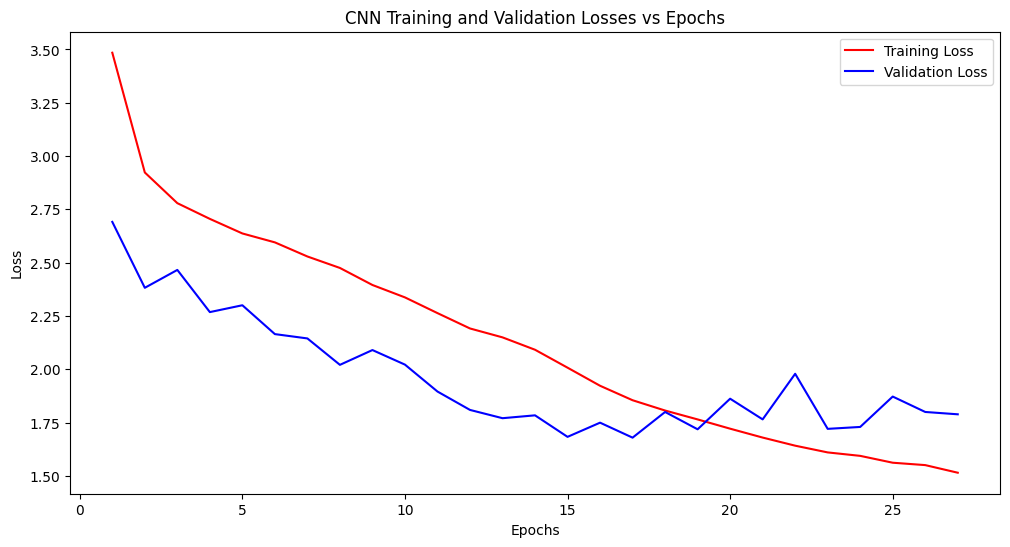

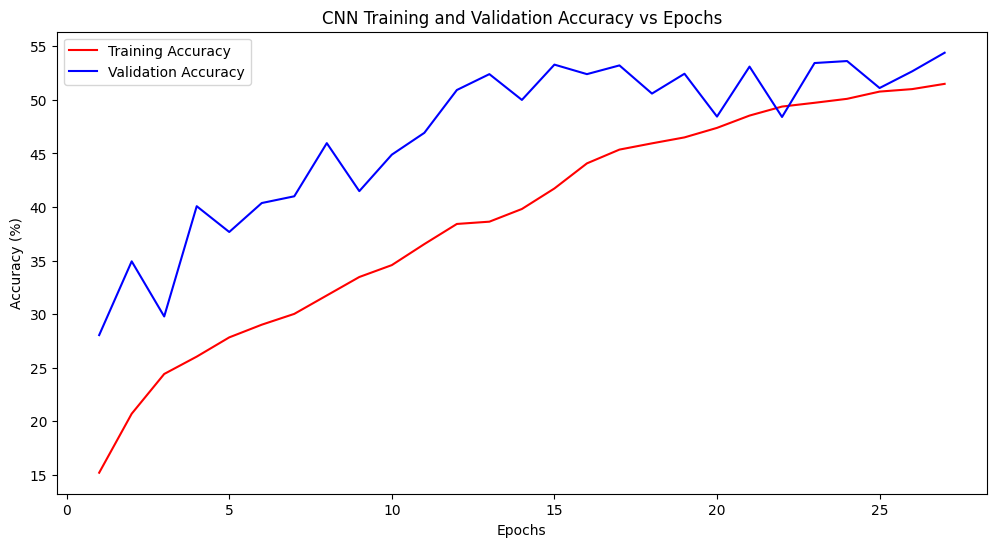

In [ ]:
plot_graphs(cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, 'CNN')

#### Hyperparameter tuning

In [ ]:
new_model_cnn.load_state_dict(torch.load('trained_cnn_model_2.3.2__.pth'))

<All keys matched successfully>

In [ ]:
new_model_cnn = new_model_cnn.to(device)

In [ ]:
# **Note:** The variable number for patience is set to reduce the execution time and is more than enough to assess the model's performance for different configurations.

criterion_cnn = nn.CrossEntropyLoss()
patience = 5
optimizer_cnn_01 = optim.Adam(new_model_cnn.parameters(), lr=0.1)
new_model_cnn_01, cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, cnn_topk = train_with_early_stopping(new_model_cnn, train_loader, val_loader, criterion_cnn, optimizer_cnn_01, num_epochs, patience, topk)

Training - Epoch [1/100], Loss: 3.5219, Accuracy: 3.42%, Top-1 Accuracy: 0.21%, Top-3 Accuracy: 0.63%, Top-5 Accuracy: 1.03%

Validation - Epoch [1/100], Loss: 3.4250, Accuracy: 3.33%, Top-1 Accuracy: 0.10%, Top-3 Accuracy: 0.31%, Top-5 Accuracy: 0.52%

Training - Epoch [2/100], Loss: 3.4486, Accuracy: 3.44%, Top-1 Accuracy: 0.21%, Top-3 Accuracy: 0.65%, Top-5 Accuracy: 1.05%

Validation - Epoch [2/100], Loss: 3.4244, Accuracy: 3.30%, Top-1 Accuracy: 0.10%, Top-3 Accuracy: 0.32%, Top-5 Accuracy: 0.52%

Training - Epoch [3/100], Loss: 3.4485, Accuracy: 3.30%, Top-1 Accuracy: 0.21%, Top-3 Accuracy: 0.64%, Top-5 Accuracy: 1.04%

Validation - Epoch [3/100], Loss: 3.4287, Accuracy: 3.33%, Top-1 Accuracy: 0.10%, Top-3 Accuracy: 0.32%, Top-5 Accuracy: 0.53%

Training - Epoch [4/100], Loss: 3.4500, Accuracy: 3.32%, Top-1 Accuracy: 0.21%, Top-3 Accuracy: 0.63%, Top-5 Accuracy: 1.06%

Validation - Epoch [4/100], Loss: 3.4259, Accuracy: 3.37%, Top-1 Accuracy: 0.11%, Top-3 Accuracy: 0.31%, Top-5 A

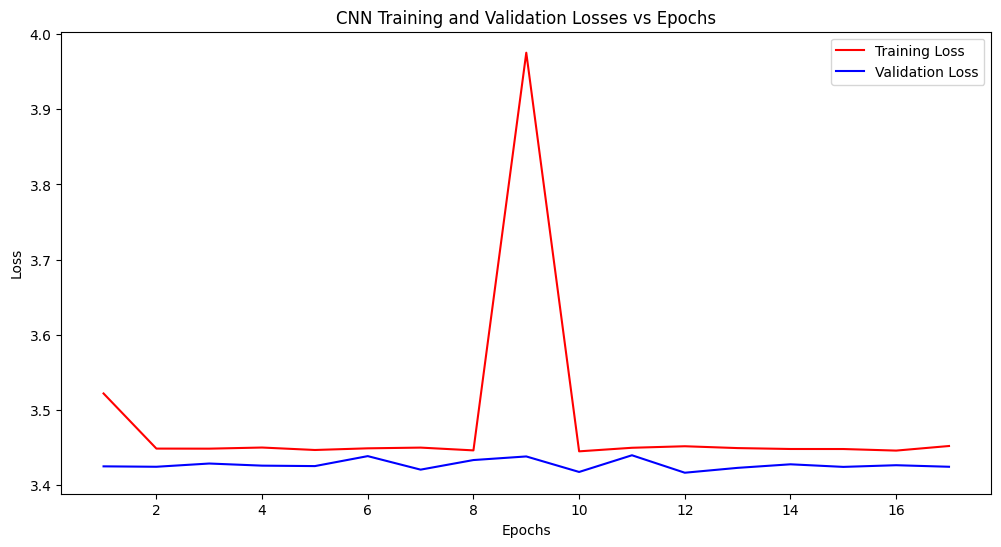

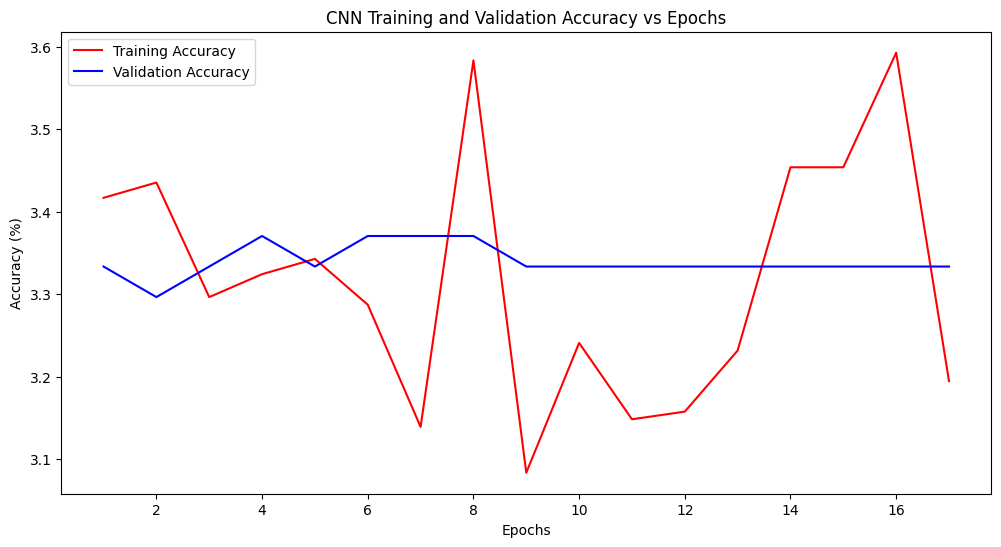

In [ ]:
plot_graphs(cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, 'CNN')

In [ ]:
train_dataset = ImgDataset (train,root_dir='/content/dataset/train_set/train_set/train_set', is_train=True, transform=transform_train)
valid_dataset = ImgDataset (valid,root_dir='/content/dataset/train_set/train_set/train_set', is_train=True, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=32, num_workers=2)

In [ ]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn_0001 = optim.Adam(new_model_cnn.parameters(), lr=0.001)
patience = 15
new_model_cnn_0001, cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, cnn_topk = train_with_early_stopping(new_model_cnn, train_loader, val_loader, criterion_cnn, optimizer_cnn_0001, num_epochs, patience, topk)

Training - Epoch [1/100], Loss: 3.1588, Accuracy: 14.45%, Top-1 Accuracy: 0.93%, Top-3 Accuracy: 1.93%, Top-5 Accuracy: 2.75%

Validation - Epoch [1/100], Loss: 2.7405, Accuracy: 28.19%, Top-1 Accuracy: 0.88%, Top-3 Accuracy: 1.55%, Top-5 Accuracy: 1.87%

Training - Epoch [2/100], Loss: 3.0893, Accuracy: 15.70%, Top-1 Accuracy: 1.02%, Top-3 Accuracy: 2.04%, Top-5 Accuracy: 2.95%

Validation - Epoch [2/100], Loss: 2.5891, Accuracy: 31.26%, Top-1 Accuracy: 0.98%, Top-3 Accuracy: 1.73%, Top-5 Accuracy: 2.12%

Training - Epoch [3/100], Loss: 3.0437, Accuracy: 17.67%, Top-1 Accuracy: 1.14%, Top-3 Accuracy: 2.22%, Top-5 Accuracy: 3.10%

Validation - Epoch [3/100], Loss: 2.4008, Accuracy: 35.85%, Top-1 Accuracy: 1.12%, Top-3 Accuracy: 1.80%, Top-5 Accuracy: 2.19%

Training - Epoch [4/100], Loss: 3.0082, Accuracy: 17.37%, Top-1 Accuracy: 1.12%, Top-3 Accuracy: 2.19%, Top-5 Accuracy: 3.18%

Validation - Epoch [4/100], Loss: 2.1827, Accuracy: 40.15%, Top-1 Accuracy: 1.26%, Top-3 Accuracy: 1.98%,

In [ ]:
torch.save(new_model_cnn_0001.state_dict(), 'trained_cnn_model_2.3.3_.pth')

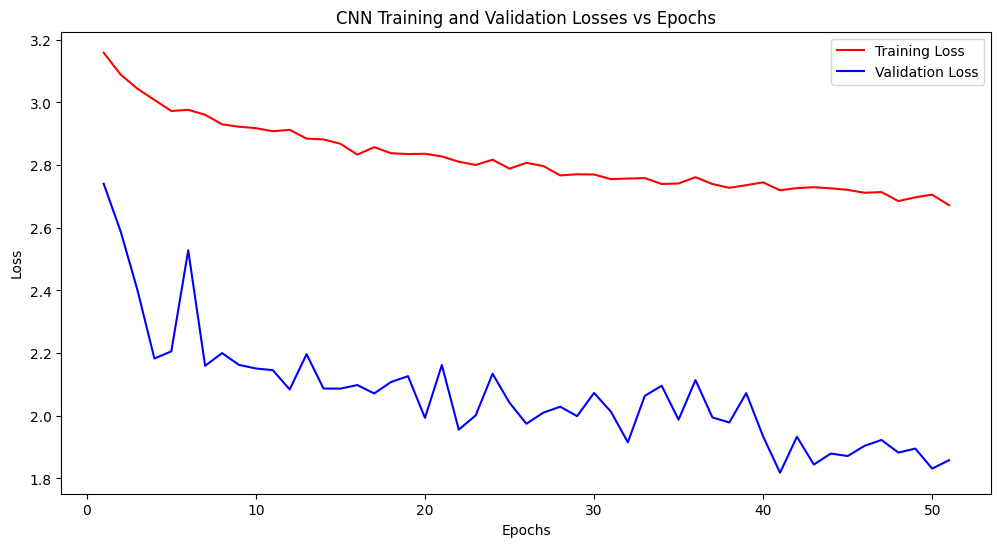

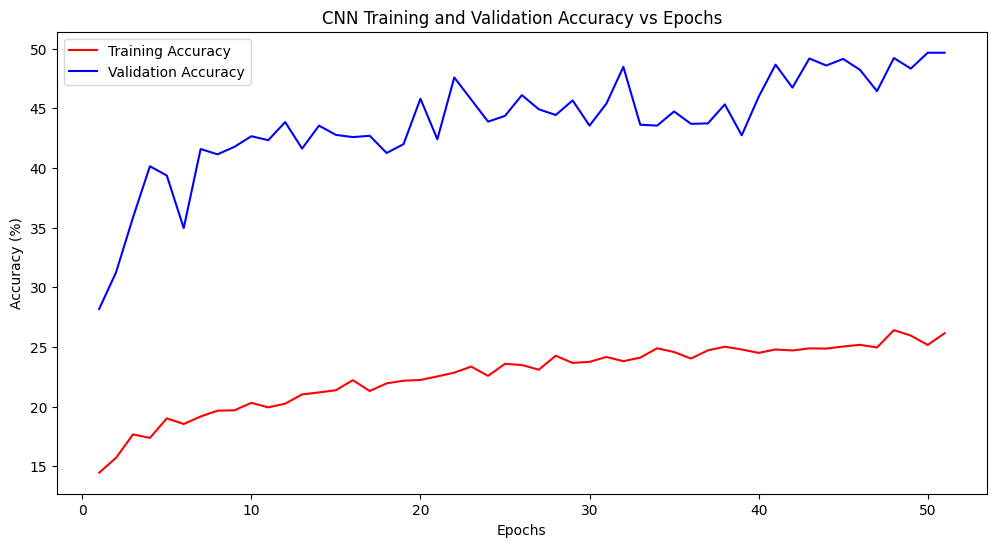

In [ ]:
plot_graphs(cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, 'CNN')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn_00001 = optim.Adam(cnn_model.parameters(), lr=0.0001)
patience = 5
new_model_cnn_00001, cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, cnn_topk = train_with_early_stopping(cnn_model, train_loader, val_loader, criterion_cnn, optimizer_cnn_00001, num_epochs, patience, topk)

Training - Epoch [1/100], Loss: 3.0473, Accuracy: 23.53%, Top-1 Accuracy: 0.37%, Top-3 Accuracy: 0.68%, Top-5 Accuracy: 0.88%

Validation - Epoch [1/100], Loss: 1.4316, Accuracy: 59.85%, Top-1 Accuracy: 0.95%, Top-3 Accuracy: 1.31%, Top-5 Accuracy: 1.42%

Training - Epoch [2/100], Loss: 2.5404, Accuracy: 27.30%, Top-1 Accuracy: 0.43%, Top-3 Accuracy: 0.78%, Top-5 Accuracy: 0.98%

Validation - Epoch [2/100], Loss: 1.4200, Accuracy: 58.22%, Top-1 Accuracy: 0.92%, Top-3 Accuracy: 1.30%, Top-5 Accuracy: 1.41%

Training - Epoch [3/100], Loss: 2.4778, Accuracy: 29.56%, Top-1 Accuracy: 0.46%, Top-3 Accuracy: 0.80%, Top-5 Accuracy: 0.99%

Validation - Epoch [3/100], Loss: 1.5016, Accuracy: 56.67%, Top-1 Accuracy: 0.90%, Top-3 Accuracy: 1.27%, Top-5 Accuracy: 1.41%

Training - Epoch [4/100], Loss: 2.4427, Accuracy: 30.23%, Top-1 Accuracy: 0.47%, Top-3 Accuracy: 0.82%, Top-5 Accuracy: 1.02%

Validation - Epoch [4/100], Loss: 1.3341, Accuracy: 61.96%, Top-1 Accuracy: 0.98%, Top-3 Accuracy: 1.32%,

In [ ]:
torch.save(new_model_cnn_00001.state_dict(), 'trained_cnn_model_for_test.pth')

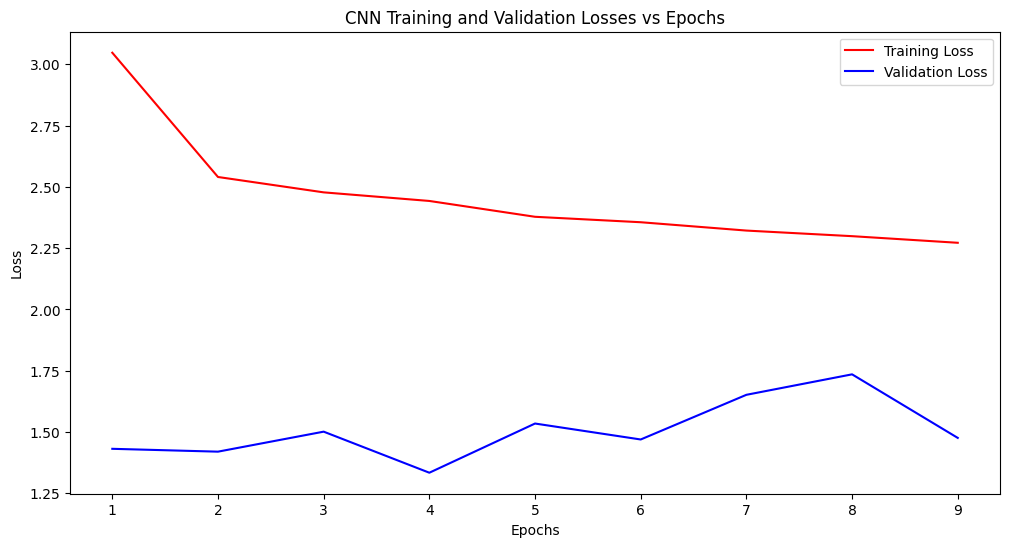

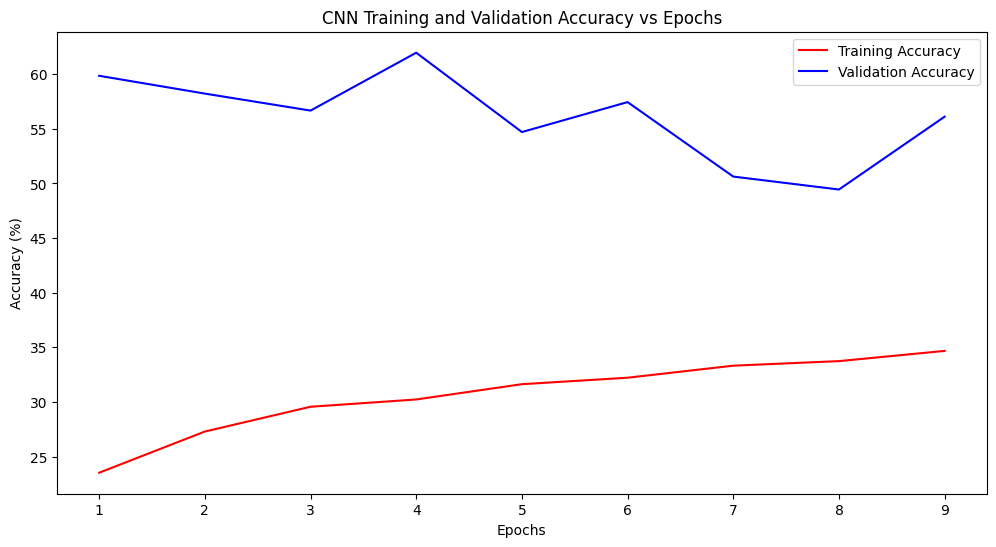

In [ ]:
plot_graphs(cnn_loss_list, cnn_accuracy_list, cnn_val_loss_list, cnn_val_accuracy_list, 'CNN')

### Model testing

In [ ]:
class ImgTestDataset(Dataset):

    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 1])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)

        label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,self.dataframe.iloc[idx, 1]

In [ ]:
test_dataframe = pd.DataFrame(enumerate(sorted(os.listdir(test_dir))))
test_dataset =ImgTestDataset (test_dataframe,root_dir='/content/dataset/test_set/test_set/test_set', transform=transform_valid)
test_loader =torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
new_model_cnn.load_state_dict(torch.load('trained_cnn_model_2.3.3_.pth'))

<All keys matched successfully>

In [ ]:
new_model_cnn = new_model_cnn.to(device)

In [ ]:
import csv

def generate_prediction_csv(model, test_loader, filename):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, image_names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for prediction, image_name in zip(predicted, image_names):
                predictions.append((image_name, prediction.item()))

    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Category']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for image_name, prediction in predictions:
            writer.writerow({'Id': image_name, 'Category': prediction})

generate_prediction_csv(new_model_cnn, test_loader, 'mm23skb.csv')



### Model Fine-tuning/transfer learning on CIFAR10 dataset


In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader_cifar = torch.utils.data.DataLoader(
    trainset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=24,
    shuffle=False,
    num_workers=2
)
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)

In [ ]:
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)

In [ ]:
alexnet_1 = alexnet

In [ ]:
criterion_con1 = nn.CrossEntropyLoss()
optimizer_con1 = optim.SGD(alexnet_1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
alexnet_1.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

In [ ]:
alexnet_1 = alexnet_1.to(device)

#### Applying transfer learning with pretrained model weights

In [ ]:
# **Note:** The patience is set to 5 and the number of epochs is reduced to 20 to reduce the execution time as we need assess the model's performance for two configurations and it is more than enough to conclude the model's performance.

%%time
patience = 5
topk=(1,3,5)
num_epochs = 20
con1_alex, con1_loss_list, con1_accuracy_list, con1_val_loss_list, con1_val_accuracy_list, con1_topk = train_with_early_stopping(alexnet_1, train_loader_cifar, testloader, criterion_con1, optimizer_con1, num_epochs, patience, topk)

Training - Epoch [1/20], Loss: 1.5729, Accuracy: 42.07%, Top-1 Accuracy: 2.63%, Top-3 Accuracy: 4.74%, Top-5 Accuracy: 5.59%
Validation - Epoch [1/20], Loss: 1.4192, Accuracy: 49.89%, Top-1 Accuracy: 2.08%, Top-3 Accuracy: 3.33%, Top-5 Accuracy: 3.83%
Training - Epoch [2/20], Loss: 1.2542, Accuracy: 55.05%, Top-1 Accuracy: 3.44%, Top-3 Accuracy: 5.30%, Top-5 Accuracy: 5.91%
Validation - Epoch [2/20], Loss: 1.2216, Accuracy: 56.03%, Top-1 Accuracy: 2.34%, Top-3 Accuracy: 3.58%, Top-5 Accuracy: 3.96%
Training - Epoch [3/20], Loss: 1.0938, Accuracy: 61.21%, Top-1 Accuracy: 3.83%, Top-3 Accuracy: 5.52%, Top-5 Accuracy: 6.00%
Validation - Epoch [3/20], Loss: 0.9747, Accuracy: 65.37%, Top-1 Accuracy: 2.73%, Top-3 Accuracy: 3.77%, Top-5 Accuracy: 4.04%
Training - Epoch [4/20], Loss: 0.9826, Accuracy: 65.38%, Top-1 Accuracy: 4.09%, Top-3 Accuracy: 5.64%, Top-5 Accuracy: 6.05%
Validation - Epoch [4/20], Loss: 0.9508, Accuracy: 67.00%, Top-1 Accuracy: 2.79%, Top-3 Accuracy: 3.78%, Top-5 Accuracy

In [ ]:
total = sum(p.numel() for p in alexnet_1.parameters())
print("Total number of trainable parameters :", total)

Total number of trainable parameters : 57023306


#### Fine-tuning model with frozen layers

In [ ]:
alexnet_2 = alexnet

In [ ]:
alexnet_2.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

In [ ]:
for param in alexnet_2.features.parameters():
    param.requires_grad = False

In [ ]:
criterion_con2 = nn.CrossEntropyLoss()
optimizer_con2 = torch.optim.SGD(alexnet_2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
alexnet_2 = alexnet_2.to(device)

In [ ]:
%%time
con2_alex, con2_loss_list, con2_accuracy_list, con2_val_loss_list, con2_val_accuracy_list, con2_topk = train_with_early_stopping(alexnet_2, train_loader_cifar, testloader, criterion_con2, optimizer_con2, num_epochs, patience, topk)

Training - Epoch [1/20], Loss: 1.8777, Accuracy: 31.90%, Top-1 Accuracy: 1.99%, Top-3 Accuracy: 4.10%, Top-5 Accuracy: 5.14%
Validation - Epoch [1/20], Loss: 1.6723, Accuracy: 39.69%, Top-1 Accuracy: 1.65%, Top-3 Accuracy: 3.07%, Top-5 Accuracy: 3.66%
Training - Epoch [2/20], Loss: 1.7430, Accuracy: 37.26%, Top-1 Accuracy: 2.33%, Top-3 Accuracy: 4.44%, Top-5 Accuracy: 5.39%
Validation - Epoch [2/20], Loss: 1.6292, Accuracy: 42.20%, Top-1 Accuracy: 1.76%, Top-3 Accuracy: 3.13%, Top-5 Accuracy: 3.72%
Training - Epoch [3/20], Loss: 1.6964, Accuracy: 39.11%, Top-1 Accuracy: 2.44%, Top-3 Accuracy: 4.53%, Top-5 Accuracy: 5.45%
Validation - Epoch [3/20], Loss: 1.5688, Accuracy: 44.83%, Top-1 Accuracy: 1.87%, Top-3 Accuracy: 3.21%, Top-5 Accuracy: 3.75%
Training - Epoch [4/20], Loss: 1.6722, Accuracy: 40.02%, Top-1 Accuracy: 2.50%, Top-3 Accuracy: 4.58%, Top-5 Accuracy: 5.47%
Validation - Epoch [4/20], Loss: 1.5703, Accuracy: 43.69%, Top-1 Accuracy: 1.82%, Top-3 Accuracy: 3.20%, Top-5 Accuracy

In [ ]:
total = sum(p.numel() for p in alexnet_2.parameters())
print("Total number of trainable parameters :", total)

Total number of trainable parameters : 57023306


#### Compare above configurations and comment on performances.

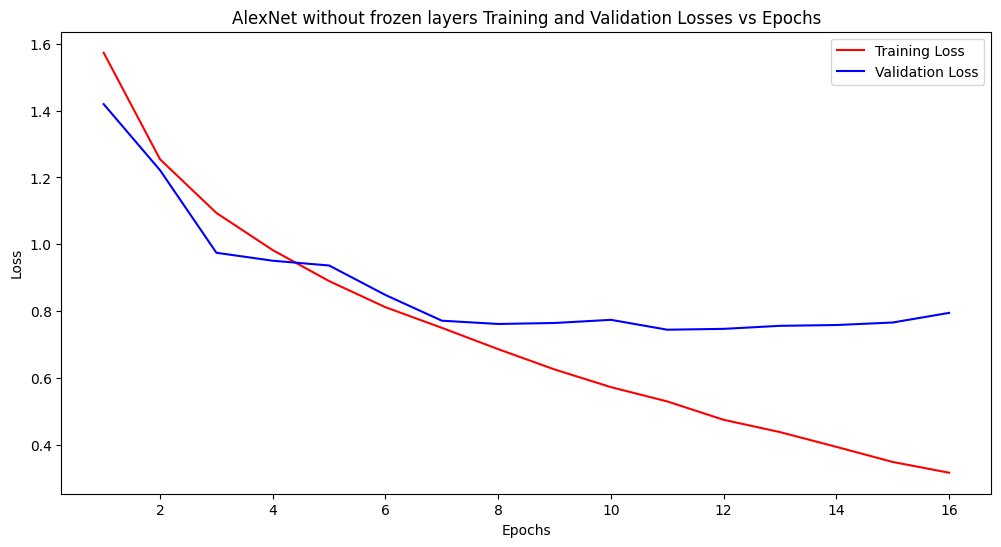

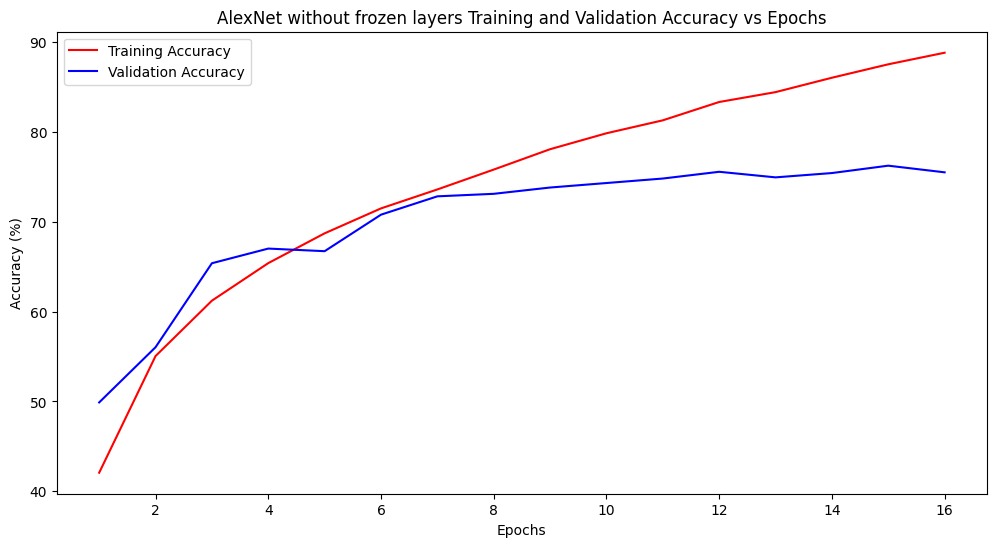

In [ ]:
plot_graphs(con1_loss_list, con1_accuracy_list, con1_val_loss_list, con1_val_accuracy_list, 'AlexNet without frozen layers')

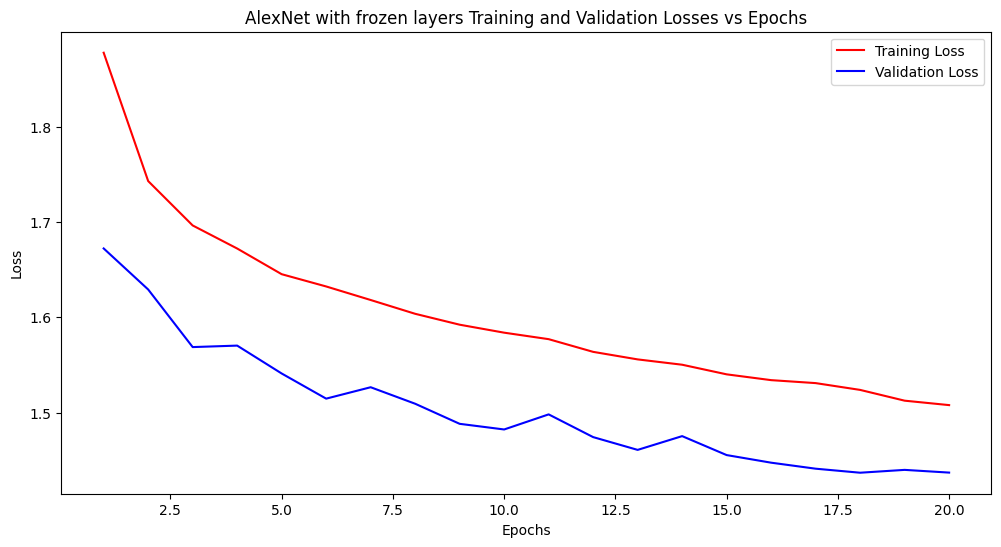

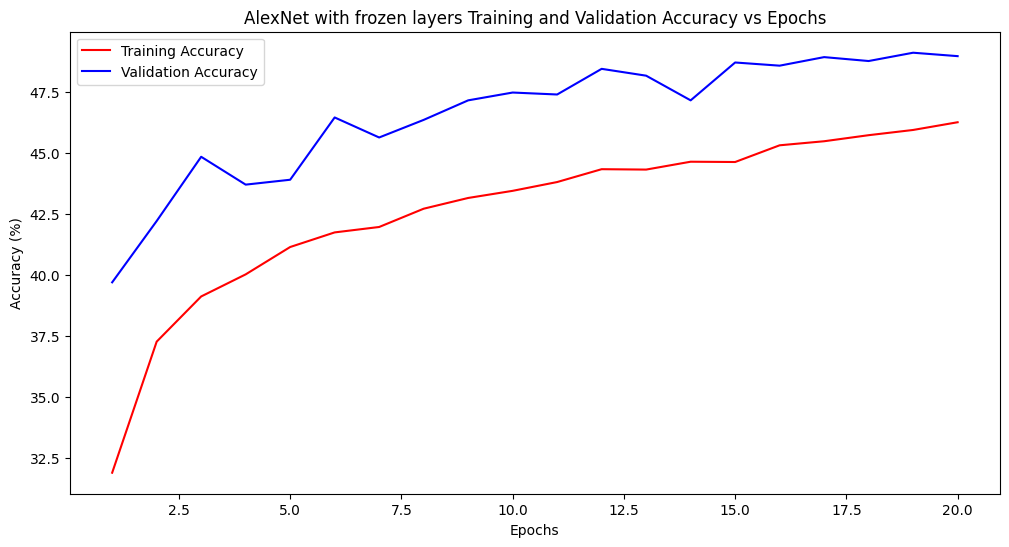

In [ ]:
plot_graphs(con2_loss_list, con2_accuracy_list, con2_val_loss_list, con2_val_accuracy_list, 'AlexNet with frozen layers')

###Comments on performance
1. Without freezing layers
  * Not freezing layers means allowing all layers of the network to be updated during training.
  * The model has an accuracy of 88% and 75% on training and validation dataset of CIFAR10 after 16 epochs with an execution time of 9min 49s.
2. With frozen layers
  * Freezing layers refers to the process of preventing the weights of certain layers from being updated during training.
  * The model has an accuracy of 46% and 48% on training and validation dataset of CIFAR10 after 20 epochs with an execution time of 9min 36s.
3. Conclusion
  * The frozen layers make the execution time less but so the accuracy as seen limiting the model's capacity to adapt to the new task.
  * By not freezing the layers the model requires a larger amount of computational resources compared to transfer learning with freezing but increased accuracy.